In [1]:
import numpy as np
import torch
import scipy
import math
import tqdm
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils import data
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.functional as F

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ChebConv

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [4]:
from torch_geometric.utils import get_laplacian
data = dataset[0]
L = get_laplacian(data.edge_index, normalization="sym")
L = torch.sparse.FloatTensor(L[0], L[1])

<center><b>Sizes of variables</b>: </center>
$$L \in M^{2708\times 2708}$$
$$Features \in R^{2708\times 1433}$$
$$Labels \in N^{2708}$$
<center>Number of classes: 7</center>

# Cheb-Convnet

In [5]:
def test(model):
    model.eval()
    _, pred = model(data.x, L).max(dim=1)
    correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()
    print('Accuracy: {:.4f}'.format(acc))

In [6]:
class Graph_Convolution_Chebychev(nn.Module):
        
        def __init__(self, F_in, F_out, K):
            super(Graph_Convolution_Chebychev, self).__init__()
            self.F_in = F_in
            self.F_out = F_out
            self.weight = Parameter(torch.FloatTensor(K, F_in, F_out))
            self.bias = Parameter(torch.FloatTensor(F_out))
            self.reset_parameters()

        def reset_parameters(self):
            stdv = 1. / math.sqrt(self.weight.size(1))
            self.weight.data.uniform_(-stdv, stdv)
            self.bias.data.fill_(0.0)
        
        def forward(self, x, L):
            Tx_0 = x.contiguous()
            out = torch.matmul(Tx_0, self.weight[0])

            if self.weight.size(0) > 1:
                Tx_1 = torch.spmm(L, x)
                out = out + torch.matmul(Tx_1, self.weight[1])

            for k in range(2, self.weight.size(0)):
                Tx_2 = 2 * torch.spmm(L, Tx_1) - Tx_0
                out = out + torch.matmul(Tx_2, self.weight[k])
                Tx_0, Tx_1 = Tx_1, Tx_2

            if self.bias is not None:
                out = out + self.bias

            return out

In [7]:
class Chebychev_convolutional_network(nn.Module):
    
    def __init__(self, net_parameters):
        super(Chebychev_convolutional_network, self).__init__()

        self.F_in, self.F_out, self.K, self.dropout = net_parameters
        self.GCN1 = Graph_Convolution_Chebychev(self.F_in, 20, K)
        self.GCN2 = Graph_Convolution_Chebychev(20, 7, K)
        
        self.FC1 = nn.Linear(50, 128)
        scale = 1. / math.sqrt(self.FC1.weight.size(1))
        self.FC1.weight.data.uniform_(-scale, scale)
        self.FC1.bias.data.fill_(0.0)
        self.FC2 = nn.Linear(128, 7)
        scale = 1. / math.sqrt(self.FC2.weight.size(1))
        self.FC2.weight.data.uniform_(-scale, scale)
        self.FC2.bias.data.fill_(0.0)
        
    def forward(self, x, L):
        x = self.GCN1(x, L)
        x = F.relu(x)
        # x = self.graph_max_pool(x, 4)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.GCN2(x, L)
        # x = self.graph_max_pool(x, 4)
        # x = x.view(-1, self.FC1Fin)
        # x = self.FC1(x)
        # x = F.relu(x)
        # x  = F.dropout(x, self.dropout, training=self.training)
        # x = self.FC2(x)
        
        return F.log_softmax(x, dim=1)  
    
    def loss(self, y, y_target, l2_regularization):
    
        loss = nn.CrossEntropyLoss()(y,y_target)

        l2_loss = 0.0
        for param in self.parameters():
            data = param* param
            l2_loss += data.sum()
           
        loss += 0.5* l2_regularization* l2_loss
            
        return loss

In [8]:
F_in = 1433
F_out = 7
K = 2
dropout = 0.2
net_parameters = [F_in, F_out, K, dropout]

cheb_net = Chebychev_convolutional_network(net_parameters)
optimizer_cheb = optim.Adam(cheb_net.parameters())
criterion = nn.CrossEntropyLoss()
test(cheb_net)

Accuracy: 0.1090


In [9]:
loss_history = np.zeros(40000) 

for epoch in tqdm.trange(40000): 
  
    outputs = cheb_net(data.x, L) # Usiamo tutto il dataset
    loss = cheb_net.loss(outputs[data.train_mask], data.y[data.train_mask], 5e-4) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_cheb.step()
    optimizer_cheb.zero_grad()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 40000/40000 [19:34<00:00, 34.06it/s]


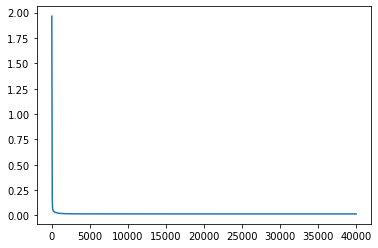

Accuracy: 0.3110
tensor(0.0155, grad_fn=<AddBackward0>)
1.9645023345947266


In [10]:
plt.plot(loss_history)
plt.show()
test(cheb_net)
print(loss)
print(loss_history[0])

### Test pytorch geometric

In [ ]:
def test(model):
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()
    print('Accuracy: {:.4f}'.format(acc))

In [ ]:
class ChebNet_pytorch_geometric(torch.nn.Module):
    def __init__(self, dataset, K):
        super(ChebNet_pytorch_geometric, self).__init__()
        self.conv1 = ChebConv(dataset.num_features, 20, K)
        self.conv2 = ChebConv(20, 7, K)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
cheb_net = ChebNet_pytorch_geometric(data, 2)
optimizer = optim.Adam(cheb_net.parameters())
criterion = nn.CrossEntropyLoss()
test(cheb_net)

loss_history = np.zeros(1000) 

for epoch in tqdm.trange(1000): 
  
    outputs = cheb_net(data) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_history[epoch] = loss.detach().numpy()

In [ ]:
plt.plot(loss_history)
plt.show()
test(cheb_net)
print(loss)
print(loss_history[0])